In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='ddd3c9b9-99b7-4e20-ac50-19906c9c8917', project_access_token='p-8c194517da1a6b37ef187169031be6359a140f1c')
pc = project.project_context


# NOTE:  
This notebook was initially based upon a Python notebook provided by Joe Kozhaya, in his Watson Developer Cloud project on Github called [wdcutils](https://github.com/joe4k/wdcutils/).

Further work to bring the code "up to date", refactor for the new [Watson Assistant](https://cloud.ibm.com/catalog/services/watson-assistant) V2 interface (as opposed to the older Watson Conversation), and to extend some of the concepts, was done by the folowing contributors:
- D. Toczala (dtoczala@us.ibm.com)


# Notebook for testing performance of intent classification in Watson Assistant Service
**[Watson Developer Cloud](https://www.ibm.com/watson/developer/)** is a platform of cognitive services that leverage machine learning techniques to help partners and clients solve a variety business problems. Furthermore, several of the WDC services fall under the **supervised learning** suite of machine learning algorithms, that is, algorithms that learn by example. This begs the questions: "How many examples should we provide?" and "When is my solution ready for prime time?"

It is critical to understand that training a machine learning solution is an iterative process where it is important to continually improve the solution by providing new examples and measuring the performance of the trained solution. In this notebook, we show how you can compute important Machine Learning metrics (accuracy, precision, recall, confusion_matrix) to judge the performance of your Watson Conversation service solution. For more details on these various metrics, please consult the **[Is Your Chatbot Ready for Prime-Time?](https://developer.ibm.com/dwblog/2016/chatbot-cognitive-performance-metrics-accuracy-precision-recall-confusion-matrix/)** blog.

You may also want to view some advice on best practices for Watson Assistant application development.  You can find these in **[Conversational Assistants and Quality with Watson Assistant](https://dtoczala.wordpress.com/2019/07/30/conversational-assistants-and-quality-with-watson-assistant/)**.

<br> The notebook assumes you have already created a **[Watson Assistant](https://cloud.ibm.com/catalog/services/watson-assistant)** service instance and trained a skill within it based on a number of intents. You will also need a Cloud Object Storage (COS) in stance with two different buckets, one for providing credential information for the this notebook, and one for storing results of the k-fold testing.</br>
<br> To leverage this notebook, you need to provide the following information:</br>

* Credentials for your Watson Conversation instance (stored in a COS file named csm_bot_creds.json)
* Credentials for your Cloud Object Storage (COS) and IBM Identity Manager (IAM)
* csv file with your text utterances and corresponding intent labels (stored in a COS file named CSM_Bot_intents.csv)

In [2]:
# %%capture
!pip install pandas_ml
!pip install ibm-watson
#
import ibm_watson
from ibm_watson import ApiException
from ibm_watson import AssistantV1
from ibm_watson import AssistantV2
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
#
import pandas as pd
import pandas_ml
from pandas_ml import ConfusionMatrix
#
#Import utilities
#
import json
import sys
import codecs
import re
import time
from os.path import join, dirname
from datetime import datetime
import unicodecsv as csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from botocore.client import Config
import ibm_boto3


# Credentials
Provide the credentials to access your Conversation service and a COS storage bucket.

In [3]:
credentials = {
#
# COS and IAM Parameters
#
#    'IAM_SERVICE_ID': the IAM service ID - you can find this on the "Service Credentials" tab, just
#                      select the service key and click on the "View Credentials" caret, and in the
#                      JSON that is shown, choose the "iam_serviceid_crn" field,
#    'IBM_API_KEY_ID': the IAM service ID - you can find this on the "Service Credentials" tab, just
#                      select the service key and click on the "View Credentials" caret, and in the
#                      JSON that is shown, choose the "apikey" field,
#    'ENDPOINT': your API endpoint.  Check the endpoints specified in COS, for your specific region, 
#                which can be found at https://cloud.ibm.com/docs/services/cloud-object-storage?topic=cloud-object-storage-endpoints
#    'IBM_AUTH_ENDPOINT': the IBM Authentiocation endpoint - https://iam.bluemix.net/oidc/token,
#    'RESULTS_BUCKET': Plain text name of the COS bucket for your results,
#    'BUCKET': Plain text name of the COS bucket you are accessing for credential information
#
    'IAM_SERVICE_ID': 'crn:v1:bluemix:public:iam-identity::a/d50fb47sjewy36597f8f2efdwe53eeds5::serviceid:ServiceId-2beye65f-2ww9-4226-beef-7363eds5233a',
    'IBM_API_KEY_ID': '84823hyrTH62UY762dlf7wmrPkZrh12eytey346dejqw7HW5N',
    'ENDPOINT': 'https://s3.us-south.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'RESULTS_BUCKET': 'my-bucket',
    'BUCKET': 'my-bucket',
#
# Assistant creds
#
#    'ASSISTANT_API_KEY': the API key for your Watson Assistant instance,
#    'ASSISTANT_VERSION': the version of the Watson Assistant API being used, generally something like '2019-02-28',
#    'ASSISTANT_URL': path to the service URL, generally this is 'https://gateway.watsonplatform.net/assistant/api',
#    'ASSISTANT_SKILL_ID': ID of the skill being worked on and tested
#
    'ASSISTANT_API_KEY': 'xxx999999999863Eshsyetd3GFotx4pBtoxtoxwesd6x',
    'ASSISTANT_VERSION': '2019-02-28',
    'ASSISTANT_URL': 'https://gateway.watsonplatform.net/assistant/api',
    'ASSISTANT_SKILL_ID': '2354west-45e4-4a23-8ac1-e6187ert5w45',
#
# Other creds
#
#    'TEST_CSV_FILE': name of the CSV file that contains the intents and utterances that you wish to test with
# Parameters for the contents of the CSV file:
#      Utterance1 , Intent1
#      Utterance2 , Intent2
#      Utterance3 , Intent3
#      etc , etc
#
    'TEST_CSV_FILE': 'My_intents.csv'
}


In [4]:
# @hidden_cell

credentials = {
    'IAM_SERVICE_ID': 'crn:v1:bluemix:public:iam-identity::a/d50fb4700dcb8797f8f2efd18a1d22f5::serviceid:ServiceId-2bbc061f-2ad9-4ac6-bfcd-7321e5ecd83a',
    'IBM_API_KEY_ID': '8d0GW7wfsmLCuf6ozXzcwmrPkZrh6bV8B4cvXNfwmY7N',
    'ENDPOINT': 'https://s3.us-south.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'RESULTS_BUCKET': 'csm-bot-bucket',
    'BUCKET': 'csm-bot-bucket',
#
# Assistant creds
#
    # The Dev instance
#    'ASSISTANT_API_KEY': 'DXRdDe8p-AiLcPUHStsFyaxTwppe7fHOTVEPVDzCTaOb',  # "writer" Assistant API key 
#    'ASSISTANT_VERSION': '2019-02-28',
#    'ASSISTANT_URL': 'https://gateway.watsonplatform.net/assistant/api',
#    'ASSISTANT_SKILL_ID': '9153068e-49c4-42a3-9ac3-e68b63e7eb85',   # using Skill ID

    # the Test instance
    'ASSISTANT_API_KEY': 'jPOesPLpJLhnqFHwZ7axHOfKGYT3AZuSgQ45pbFHo2BV',  # "writer" Assistant API key 
    'ASSISTANT_VERSION': '2019-02-28',
    'ASSISTANT_URL': 'https://gateway.watsonplatform.net/assistant/api',
    'ASSISTANT_SKILL_ID': 'e0458a1f-0ef7-4c29-8210-f449d12ee94b',   # using Skill ID

    #
# Other creds
#
    'TEST_CSV_FILE': 'CSM_Bot_intents.csv'
}


# Setup Cloud Object Storage (COS)


In [5]:
#
# Grab creds file from COS storage
#
# IBM COS interface

def __iter__(self): return 0
from ibm_botocore.client import Config

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])


# Read your Test Data File from the file in COS
Here we will read the Test Data (the one specified as TEST_CSV_FILE) file from COS to the virtual environment.  We'll also set the credentials for the Watson Assistant instance.

In [6]:
#
# Set all required parameters
# 
assist_api_key=credentials['ASSISTANT_API_KEY']
wa_version=credentials['ASSISTANT_VERSION']
wa_url=credentials['ASSISTANT_URL']
assist_workspace_id=credentials['ASSISTANT_SKILL_ID']
test_csv_file=credentials['TEST_CSV_FILE']
#
# Read in the test CSV file from COS
#
testcsvFilename = './'+ test_csv_file
#
cos.download_file(Filename=testcsvFilename,Bucket=credentials['BUCKET'],Key=test_csv_file)

# Get an object for your Watson Assistant instance

In [7]:
# Create an object for your Conversation instance
# Make sure to update the version to match your WCS workspace
#assistant = AssistantV1(
#  username=user,
#  password=password,
#  version='2019-02-28')

#assistant_v1 = AssistantV1(version='2019-02-28',
#    url=assist_url,
#    iam_apikey=assist_apikey,
#    iam_url=iam_url)
#assistant_v2 = AssistantV2(version='2019-02-28',
#    url=assist_url,
#    iam_apikey=assist_apikey,
#    iam_url=iam_url)

authenticator=IAMAuthenticator(assist_api_key)

assistant_v1=ibm_watson.AssistantV1(
    version = wa_version,
    authenticator = authenticator
    )
assistant_v1.set_service_url(wa_url)

# Read initial CSV file of utterances and intents
Now we are going to read our input CSV of utternaces and intents, and create a dict structure based on the utterances, and a second dict structure which contains a list of the unique intents, and a count of examples (utterances) for each of these intents.

In [8]:
#DEBUG = True
DEBUG = False

test_classes=[]
intent_data_dict= {}
intent_classes_dict= {}
print ('reading csv file: ', test_csv_file)
with open(test_csv_file,"rb") as csvfile:
        # For better handling of utf8 encoded text
        csvReader = csv.reader(csvfile, encoding="utf-8-sig")
        for row in csvReader:
            # Assume input text is 2 column csv file, first column is text
            # and second column is the label/class/intent
            # Sometimes, the text string includes commas which may split
            # the text across multiple colmns. The following code handles that.
            if len(row) > 2:
                qelements = row[0:len(row)-1]
                utterance = ",".join(qelements)
                test_classes.append(row[len(row)-1])
            else:
                utterance = row[0]
                this_class = row[1]
                test_classes.append(row[1])
            utterance = utterance.replace('\s', ' ')
            #
            # If valid data, store it in a dict for all of our intent data
            #
            if (utterance != "") and (utterance != "#VALUE!") and (utterance != "Utterance"):
                intent_data_dict.update({utterance : this_class})
                #
                # Store the count of each intent class occurring
                #
                if this_class in intent_classes_dict :
                    intent_classes_dict[this_class] = intent_classes_dict[this_class] + 1
                else:
                    intent_classes_dict[this_class] = 1
#
# Now show what is in each testing class
#
if (DEBUG):
    print ("Our values...")
    for (utterance, intent) in intent_data_dict.items() :
        print (utterance, " -> ", intent)
    #
    #
    #
    print ("\n\nOur intents...")
    print ("NOTE: Intents with fewer than 10 utterances will NOT provide valid K-fold results! \n")
    for (item, count) in intent_classes_dict.items() :
        print (count, " occurances of Intent - ", item)
    

reading csv file:  CSM_Bot_intents.csv


# Break initial CSV file of utterances and intents into 5 K-fold train/test sets
Now we are going to break the initial CSV file into 5 sets of training and test data sets.
We'll do this by creating 5 new sets of CSV files, each with a distribution of 20% of each intent for test data, and 80% of each intents for training data.  I could try to make this random, but I don't have the time today.  Instead, we will take the data for each intent, and break it into five pieces.  So you will see something like this:

**Intent A** -> split into 5 pieces, A1, A2, A3, A4, and A5.
**Intent B** -> split into 5 pieces: B1, B2, B3, B4, and B5.

**Training set 1** -> A2 + A3 + A4 + A5 + B2 + B3 + B4 + B5
**Test Set 1** -> A1 + B1

**Training set 2** -> A1 + A3 + A4 + A5 + B1 + B3 + B4 + B5
**Test set 2** -> A2 + B2

**Training set 3** -> A1 + A2 + A4 + A5 + B1 + B2 + B4 + B5
**Test set 3** -> A3 + B3

**Training set 4** -> A1 + A2 + A3 + A5 + B1 + B2 + B3 + B5
**Test set 4** -> A4 + B4

**Training set 5** -> A1 + A2 + A3 + A4 + B1 + B2 + B3 + B4
**Test set 5** -> A5 + B5


In [9]:
#DEBUG = True
DEBUG = False
FOLD_MAX=5
TrainSet1_dict = {}
TestSet1_dict = {}
TrainSet2_dict = {}
TestSet2_dict = {}
TrainSet3_dict = {}
TestSet3_dict = {}
TrainSet4_dict = {}
TestSet4_dict = {}
TrainSet5_dict = {}
TestSet5_dict = {}
#
# Start building your k-fold lists
#
# Loop through each intent
#
for (target_intent, intent_count) in intent_classes_dict.items() :
    #
    if (intent_count < 10) :
        print ("WARNING: ", intent_count, " occurances of Intent - ", target_intent, " is too few for accurate K-fold testing.")
    #
    # Set fold counter to 1
    #
    fold_count = 0
    #
    # Loop through input data, look for matches to your target intent, and then write to approriate test/training sets
    #
    for (utterance, intent) in intent_data_dict.items() :
        #
        if (intent == target_intent) :
            #
            fold_count += 1
            #
            fold_target = fold_count % FOLD_MAX
            #
            # Add to the appropriate sets of test/training data
            #
            if (fold_target == 0):
                #
                # In group A1
                #
                TestSet1_dict.update({utterance : intent})
                TrainSet2_dict.update({utterance : intent})
                TrainSet3_dict.update({utterance : intent})
                TrainSet4_dict.update({utterance : intent})
                TrainSet5_dict.update({utterance : intent})
            if (fold_target == 1):
                #
                # In group A2
                #
                TestSet2_dict.update({utterance : intent})
                TrainSet1_dict.update({utterance : intent})
                TrainSet3_dict.update({utterance : intent})
                TrainSet4_dict.update({utterance : intent})
                TrainSet5_dict.update({utterance : intent})
            if (fold_target == 2):
                #
                # In group A3
                #
                TestSet3_dict.update({utterance : intent})
                TrainSet1_dict.update({utterance : intent})
                TrainSet2_dict.update({utterance : intent})
                TrainSet4_dict.update({utterance : intent})
                TrainSet5_dict.update({utterance : intent})
            if (fold_target == 3):
                #
                # In group A4
                #
                TestSet4_dict.update({utterance : intent})
                TrainSet1_dict.update({utterance : intent})
                TrainSet2_dict.update({utterance : intent})
                TrainSet3_dict.update({utterance : intent})
                TrainSet5_dict.update({utterance : intent})
            if (fold_target == 4):
                #
                # In group A5
                #
                TestSet5_dict.update({utterance : intent})
                TrainSet1_dict.update({utterance : intent})
                TrainSet2_dict.update({utterance : intent})
                TrainSet3_dict.update({utterance : intent})
                TrainSet4_dict.update({utterance : intent})
            #
            # go to next set of input data
        #
        # go to next intent

#
# Now see how you split things up
#
if (DEBUG):
    print ("Test set 1...")
    for (utterance, intent) in TestSet1_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 1...")
    for (utterance, intent) in TrainSet1_dict.items() :
        print (utterance, " -> ", intent)
    #
    print ("\nTest set 2...")
    for (utterance, intent) in TestSet2_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 2...")
    for (utterance, intent) in TrainSet2_dict.items() :
        print (utterance, " -> ", intent)
    #
    print ("\nTest set 3...")
    for (utterance, intent) in TestSet3_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 3...")
    for (utterance, intent) in TrainSet3_dict.items() :
        print (utterance, " -> ", intent)
    #
    print ("\nTest set .4..")
    for (utterance, intent) in TestSet4_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 4...")
    for (utterance, intent) in TrainSet4_dict.items() :
        print (utterance, " -> ", intent)
    #
    print ("\nTest set 5...")
    for (utterance, intent) in TestSet5_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 5...")
    for (utterance, intent) in TrainSet5_dict.items() :
        print (utterance, " -> ", intent)                

# Watson Assistant V1 methods
Define useful methods to classify using trained Watson Assistant service.

In [10]:
# Given a pointer to an Assistamt instance and a workspace ID, go and delete a workspace, get back status
def deleteAssistantWorkspace(assist_instance,workspaceID):
    context={}
    MAX_ATTEMPTS = 2
    tries = 0
    need_results = True
    while (need_results and (tries < MAX_ATTEMPTS)):
        try:
            response = assist_instance.delete_workspace(
                workspace_id=workspaceID)
            need_results = False
        except Exception as e:
            print("will retry after error", e)
            tries += 1
            time.sleep(5)
        # end of loop to retry

    if tries < MAX_ATTEMPTS:
        workspaceStatus=response.get_result()
        
    return workspaceStatus

# Given a pointer to an Assistamt instance and workspaceID, get back Assistantkeep checking the workspace
# and don't return until workspace is "Available" - return true if workspace is available, false if timeout
# reached 
def waitAssistantWorkspace(assist_instance,workspaceID,timeout):
    stat=False
    MAX_ATTEMPTS = int (timeout // 5)
    tries = 0
    while (stat == False) and (tries < MAX_ATTEMPTS):
        try:
            response = assist_instance.get_workspace(
                workspace_id=workspaceID)
        except:
            tries += 1
            time.sleep(5)
            sys.stdout.write('.')
            continue
        #
        # Now check the status
        #
        settings = response.get_result()
        if (settings['status'] == "Available"):
            stat=True
            break
        else:
            tries += 1
            time.sleep(5)
            sys.stdout.write('.')
        # end of loop to retry 
    return stat

# Given a pointer to an Assistamt instance create a workspace, get back Assistant workspace ID
def createAssistantWorkspace(assist_instance):
    context={}
    MAX_ATTEMPTS = 2
    tries = 0
    need_results = True
    while (need_results and (tries < MAX_ATTEMPTS)):
        try:
            response = assist_instance.create_workspace(
                name='Test Tox Workspace',
                description='auto-generated workspace for k-fold testing')
            need_results = False
        except Exception as e:
            print("will retry after error", e)
            tries += 1
            time.sleep(5)

        # end of loop to retry 
    if (not need_results):
        workspaceInfo=response.get_result()
        workspaceID = workspaceInfo['workspace_id']
        stat = waitAssistantWorkspace(assist_instance,workspaceID,30)
        if not stat:
            print ("\nERROR - Workspace not ready within 300 seconds. \n")
            
    return workspaceID

# Given a pointer to an Assistamt instance and workspaceID, get back Assistant workspace settings
def getAssistantWorkspaceContent(assist_instance,workspaceID):
    settings={}
    MAX_ATTEMPTS = 3
    tries = 0
    need_results = True
    while (need_results and (tries < MAX_ATTEMPTS)):
        try:
            response = assist_instance.get_workspace(
                workspace_id=workspaceID, 
                export='true')
            need_results = False
        except Exception as e:
            print("will retry after error", e)
            tries += 1
            time.sleep(5)
        # end of loop to retry
        
    if tries < MAX_ATTEMPTS:
        settings=response.get_result()
    return settings

# Given a pointer to an Assistamt instance and workspaceID, get back Assistant workspace intents
def getAssistantWorkspaceIntents(assist_instance,workspaceID):
    context={}
    intent_list=[]
    MAX_ATTEMPTS = 3
    tries = 0
    need_results = True
    while (need_results and (tries < MAX_ATTEMPTS)):
        try:
            response = assist_instance.list_intents(
                workspace_id=workspaceID)
            need_results = False
        except Exception as e:
            print("will retry after error", e)
            tries += 1
            time.sleep(5)
        # end of loop to retry 
        
    if tries < MAX_ATTEMPTS:
        settings=response.get_result()
        theseIntents=settings['intents']
        for eachIntent in theseIntents:
            thisIntent = eachIntent['intent']
            intent_list.append(thisIntent)
            
    return intent_list

# Given a pointer to an Assistamt instance and workspaceID, delete all Assistant workspace intents
def deleteAssistantWorkspaceIntents(assist_instance,workspaceID,intent_list):
    stat=True
    MAX_ATTEMPTS = 3
    tries = 0
    #
    for this_intent in intent_list:
        while (stat and (tries < MAX_ATTEMPTS)):
            try:
                response = assist_instance.delete_intent(
                    workspace_id=workspaceID,
                    intent=this_intent)
                stat = False
            except Exception as e:
                print("will retry after error", e)
                tries += 1
                time.sleep(5)
            # end of loop to retry
            
        # end of loop thru intent list
    return stat

# Given a pointer to an Assistamt instance and a workspace ID, go and create a set of intents based on a list of intents, 
# and then go and train those intents using a set of training data with utterance/intent pairs.
def trainAssistantWorkspaceIntents(assist_instance,workspaceID,intentlist_dict,trainingData_dict):
    context={}
    MAX_ATTEMPTS = 3
    DEBUG=True
    #
    # Add the intents
    #
    for (thisIntent,count) in intentlist_dict.items() :
        tries = 0
        stat = waitAssistantWorkspace(assist_instance,workspaceID,30)
        while (stat and (tries < MAX_ATTEMPTS)):
            try:
                response = assist_instance.create_intent(
                    workspace_id=workspaceID,
                    intent=thisIntent)
                stat = False
                if (DEBUG):
                    print ("Created intent ", thisIntent)
            except Exception as e:
                print("will retry after error", e)
                tries += 1
                time.sleep(5)
            # end of loop to retry
            
        #
        # Now let's train this intent
        #
        # First gather all utterances into an array
        #
        utteranceList = []
        for (thisUtterance,intendedIntent) in trainingData_dict.items() :
            if (thisIntent == intendedIntent):
                utteranceList.append(thisUtterance)
        #
        # Go add these examples to the intent for trianing
        #
        stat = waitAssistantWorkspace(assist_instance,workspaceID,300)
        tries = 0
        #
        while (stat and (tries < MAX_ATTEMPTS)):
            try:
                response = assist_instance.update_intent(
                    workspace_id=workspaceID,
                    intent=thisIntent,
                    new_examples=[
                        {'text': val}
                        for val in utteranceList]
                    )    
                stat = False
                if (DEBUG):
                    print ("trained for ", thisIntent)
            except Exception as e:
                print("will retry after error", e)
                tries += 1
                time.sleep(5)
        
            #end of loop to set intents
        
        stat = waitAssistantWorkspace(assist_instance,workspaceID,300)
        if DEBUG:
            if stat:
                print (" - success\n")
            else:
                print (" - failed to complete within 300 seconds.\n")
            
        sys.stdout.write('.')
        #end of loop to set intents
        
    print ("\nInputs to training completed")
    #
    # Now wait until workspace has finished digesting the training data
    #
    stat = waitAssistantWorkspace(assist_instance,workspaceID,300)
    if DEBUG:
        if stat:
            print ("\nDone training - success\n")
        else:
            print ("\nDone training - failed to complete within 300 seconds.\n")
    
    DEBUG=False
    return stat

# Given a text string and a pointer to Conversation instance and workspaceID, get back Conversation response
def getAssistantResponse(assist_instance,workspaceID,string):
    context={}
    stat = True
    MAX_ATTEMPTS = 3
    tries = 0
    # remove newlines from input text as that causes WCS to return an error
    string = string.replace("\n","")
    while (stat and (tries < MAX_ATTEMPTS)):
        try:
            response = assist_instance.message(
                workspace_id=workspaceID, 
                input={'text':string},
                context=context)
            stat = False
        except Exception as e:
            print("will retry after error", e)
            tries += 1
            time.sleep(5)
        # end of loop to retry
        
    classes=response.get_result()
    
    return classes

# Process multiple text utterances (provided via utterance/intent dict) in batch. Effectively, read each text
# utterance, and get the response. Aggregate and return results.
def batchAssistant(assist_instance,workspaceID,datafile_dict):
    test_classes=[]
    convpredict_classes=[]
    convpredict_confidence=[]
    text=[]
    i=0
    for (utterance, intent) in datafile_dict.items() :
        i += 1
        test_classes.append(intent)
        if (DEBUG):
            print ('i: ', i, ' v1 testing row: ', utterance)
        #
        conv_response = getAssistantResponse(assist_instance,workspaceID,utterance)
        if conv_response['intents']: 
            convpredict_classes.append(conv_response['intents'][0]['intent'])
            convpredict_confidence.append(conv_response['intents'][0]['confidence'])
        else:
            convpredict_classes.append('')
            convpredict_confidence.append(0)
        text.append(utterance)
        if(i%250 == 0):
            print("")
            print('Processed ', i, ' records')
        if(i%10 == 0):
            sys.stdout.write('.'),
    print("")
    print ('Finished processing ', i, ' records')
    return test_classes, convpredict_classes, convpredict_confidence, text

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix,labels,csvfile):
    with open(csvfile, 'wb') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)
            

# Watson Assistant V2 methods
Define useful methods to classify using trained Watson Assistant service.

**NOTE** I HAVE NOT TESTED THESE YET!!!

In [11]:
# Given a text string and a pointer to Conversation instance and workspaceID, get back Conversation response
def getAssistantResponse_v2(assist_instance,assistID,sessionID,string):
    context={}
    MAX_ATTEMPTS = 3
    tries = 0
    # remove newlines from input text as that causes WCS to return an error
    string = string.replace("\n","")
    #
    # Begin a session
    #
    while True:
        try:
            response = assist_instance.create_session(
                assistant_id=assistID)
        except:
            if tries < MAX_ATTEMPTS:
                tries += 1
                time.sleep(1)
                continue
            break
        break
    # end of loop to start session
    
    sessionID = response.get_result()
   
    while True:
        try:
            response = assist_instance.message(
                assistant_id=assistID,
                session_id=sessionID,
                input={'text':string},
                context=context)
        except:
            if tries < MAX_ATTEMPTS:
                tries += 1
                time.sleep(1)
                continue
            break
        break
    # end of loop to retry 
#    classes=response
    classes=response.get_result()
    return classes

# Process multiple text utterances (provided via csv file) in batch. Effectively, read the csv file and for each text
# utterance, get NLC response. Aggregate and return results.
def batchAssistant_v2(assist_instance,assistID,csvfile):
    test_classes=[]
    asstpredict_classes=[]
    asstpredict_confidence=[]
    text=[]
    i=0
    print ('reading csv file: ', csvfile)
    with open(csvfile,"rb") as csvfile:
        # For better handling of utf8 encoded text
        csvReader = csv.reader(csvfile, encoding="utf-8-sig")
        for row in csvReader:
            # Assume input text is 2 column csv file, first column is text
            # and second column is the label/class/intent
            # Sometimes, the text string includes commas which may split
            # the text across multiple colmns. The following code handles that.
            if len(row) > 2:
                qelements = row[0:len(row)-1]
                utterance = ",".join(qelements)
                test_classes.append(row[len(row)-1])
            else:
                utterance = row[0]
                test_classes.append(row[1])
            utterance = utterance.replace('\r', ' ')
            print ('i: ', i, ' testing row: ', utterance)

            asst_response = getAssistantResponse_v2(assist_instance,assistID,utterance)
            if asst_response['intents']: 
                asstpredict_classes.append(asst_response['intents'][0]['intent'])
                asstpredict_confidence.append(asst_response['intents'][0]['confidence'])
            else:
                asstpredict_classes.append('')
                asstpredict_confidence.append(0)
            text.append(utterance)
            i = i+1
            if(i%250 == 0):
                print("")
                print('Processed ', i, ' records')
            if(i%10 == 0):
                sys.stdout.write('.'),
        print("")
        print ('Finished processing ', i, ' records')
    return test_classes, asstpredict_classes, asstpredict_confidence, text

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix,labels,csvfile):
    with open(csvfile, 'wb') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)
            

# Go and Save off a copy of the existing Assistant data

In [12]:
DEBUG=False
UNDERSCORE = '_'
#
# First get current date/time
#
myDatetime = datetime.now()
if (DEBUG):
    print (myDatetime)
myDatetime = re.sub(r'\s',UNDERSCORE,str(myDatetime))
goodDatetime,junk = myDatetime.split('.')
#
# Build filename
#
Workspace_file = 'Assistant_Workspace_'+goodDatetime+'.json'
Workspace_path = './'+ Workspace_file
#
# Can we access the service at all?
#
myDatetime = datetime.now()
#
if (DEBUG):
    print ("Getting the Assistant workspace definition....\n")
    print ("Workspace ID is - " + assist_workspace_id)
#
Assistant_content=getAssistantWorkspaceContent(assistant_v1,assist_workspace_id)
#
if (DEBUG):
    print ("Dumping the Assistant workspace definition....")
    #
    for (x, y) in Assistant_content.items() :
        print (x, y)
#
#DEBUG = False
#
f = open (Workspace_file,"w")
for (x, y) in Assistant_content.items() :
    f.write(str(x)  + " : " + str(y) + "\n")
f.close()
#
# Write Assistant settings out to COS
#
cos.upload_file(Filename=Workspace_path,Bucket=credentials['RESULTS_BUCKET'],Key=Workspace_file)
#
print ("Prior workspace settings saved off to file " + Workspace_file + " in results area.")

Prior workspace settings saved off to file Assistant_Workspace_2020-01-28_21:05:30.json in results area.


# Run through each test scenario
This is hardcoded to do k-fold testing with a K value = 5 right now.

Steps are as follows:
1. Create a test workspace
2. Load in training data
3. Run tests with test data against test workspace
4. Collect results
5. Delete test workspace

In [13]:
AllPredict_Classes=[]
AllPredict_Confidence=[]
AllTestClasses=[]
AllText=[]
#DEBUG = True
DEBUG = False
#
# Do Scenario #1
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet1_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet1_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
#TOXTOXTOX
#stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)
#
# Do Scenario #2
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet2_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet2_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
#TOXTOXTOX
#stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)
#
# Do Scenario #3
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet3_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet3_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
#TOXTOXTOX
#stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)
#
# Do Scenario #4
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet4_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet4_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
#TOXTOXTOX
#stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)
#
# Do Scenario #5
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet5_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet5_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
#TOXTOXTOX
#stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)

Created intent  anything_else
trained for  anything_else
............ - success

.Created intent  feedback
...........trained for  feedback
.......... - success

.Created intent  general_greeting
..........trained for  general_greeting
...... - success

.Created intent  general_thanks
..........trained for  general_thanks
.............. - success

.Created intent  insult
..........trained for  insult
.......... - success

.Created intent  person_account_owner
.......trained for  person_account_owner
............. - success

.Created intent  person_csm
.............trained for  person_csm
.......... - success

.Created intent  person_om
.........trained for  person_om
............. - success

.Created intent  person_support
...........trained for  person_support
.......... - success

.Created intent  plan_info
.............trained for  plan_info
......... - success

.Created intent  readme
..........trained for  readme
......... - success

.Created intent  site_help
.......trained for  

# Now collect and dump your raw testing results to CSV

In [14]:
#
# Write results out to Cloud Object Storage
#
DEBUG=False
#DEBUG=True
#
# Build filename
#
csvFilename = 'Results_'+goodDatetime+'.csv'
csvfileOut = './'+ csvFilename

# print results to csv file including original text, the correct label, 
# the predicted label and the confidence reported by Conversation.
csvWriter = codecs.open(csvfileOut, 'w', encoding="utf-8-sig")

outrow=['text','true class','Assistant Predicted class','Confidence']
csvWriter.write("text"+","+"true class"+","+"Assistant Predicted class"+","+"Confidence")
csvWriter.write("\n")

for i in range(len(AllText)):
    t = AllText[i]
    txt = AllText[i]
    if (DEBUG):
        print (AllText[i])
    if txt[:1] != '"' or txt.strip()[-1] != '"':
        txt = "\"" + txt + "\""
    csvWriter.write(txt+","+AllTestClasses[i]+","+AllPredict_Classes[i]+","+str(AllPredict_Confidence[i]))
    csvWriter.write("\n")
csvWriter.close()
#
# Write results out to Cloud Object Storage
#
cos.upload_file(Filename=csvfileOut,Bucket=credentials['RESULTS_BUCKET'],Key=csvFilename)

# Write Confusion Matrix results out

In [15]:
# Compute confusion matrix
labels=list(set(AllTestClasses))
assist_confusion_matrix = confusion_matrix(AllTestClasses, AllPredict_Classes, labels)
assistConfMatrix = ConfusionMatrix(AllTestClasses, AllPredict_Classes)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [16]:
#
# Build filename
#
confmatrix_csv_filename = 'Confusion_'+goodDatetime+'.csv'
confmatrix_csv_file = './'+ confmatrix_csv_filename
#
# Print out confusion matrix with labels to csv file
#
confmatrix2csv(assist_confusion_matrix,labels,confmatrix_csv_file)
#
# Write results out to Cloud Object Storage
#
cos.upload_file(Filename=confmatrix_csv_file,Bucket=credentials['RESULTS_BUCKET'],Key=confmatrix_csv_filename)

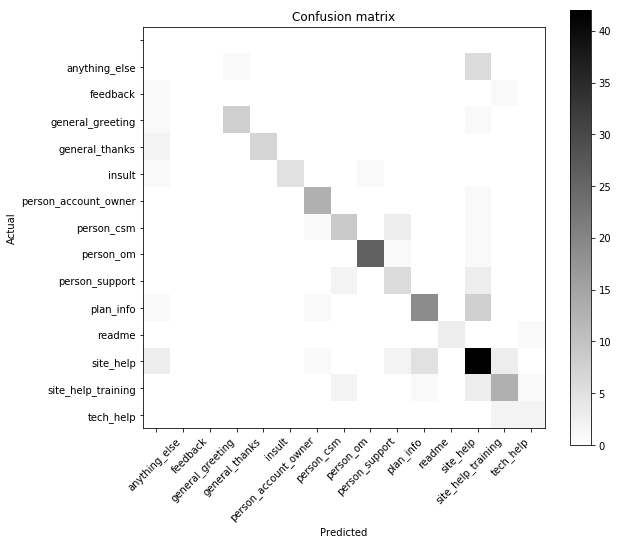

In [17]:
#%matplotlib inline
assistConfMatrix.plot()

In [18]:
# Compute accuracy of classification
acc=accuracy_score(AllTestClasses, AllPredict_Classes)
print ('Classification Accuracy: ', acc)

Classification Accuracy:  0.7116279069767442


In [ ]:
# print precision, recall and f1-scores for the different classes
print(classification_report(AllTestClasses, AllPredict_Classes, labels=labels))

                      precision    recall  f1-score   support

      general_thanks       1.00      0.78      0.88         9
    general_greeting       0.89      0.80      0.84        10
           site_help       0.64      0.75      0.69        56
            feedback       0.00      0.00      0.00         2
              readme       1.00      0.75      0.86         4
       anything_else       0.00      0.00      0.00         7
              insult       1.00      0.71      0.83         7
      person_support       0.50      0.55      0.52        11
           tech_help       0.50      0.50      0.50         4
          person_csm       0.69      0.64      0.67        14
           person_om       0.96      0.93      0.95        28
person_account_owner       0.81      0.93      0.87        14
  site_help_training       0.68      0.65      0.67        20
           plan_info       0.76      0.66      0.70        29

           micro avg       0.74      0.71      0.73       215
      

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#Optional if you would like each of these metrics separately
#[precision,recall,fscore,support]=precision_recall_fscore_support(AllTestClasses, AllPredict_Classes, labels=labels)
#print ('precision: ', precision)
#print ('recall: ', recall)
#print ('f1 score: ', fscore)
#print ('support: ', support)

# Now see if user wants to apply this against their current skill

Ask the user if they want to apply this against their current skill - and if they do, then go and delete all current intents, and then create the new intents and apply ALL of the new training data.

In [ ]:
#DEBUG=True
DEBUG=False
stat=True
#
# Remind user whgat their target workspace/skill is - and then ask the question
#
#
Assistant_content=getAssistantWorkspaceContent(assistant_v1,assist_workspace_id)
#
if (DEBUG):
    print(json.dumps(Assistant_content, indent=2))
print ('Workspace/Skill name - ', Assistant_content['name'])
print ('          Description -', Assistant_content['description'])
#
Apply = input('Would you like to apply this data against your current skill/workspace? (yes/no)').lower()
if Apply != 'yes':   
    print ('New data not applied - Processing complete.')
else:
    print ('Removing old intent, and applying new training data...')
    #
    # Otherwise we are applying against the current skill/workspace
    #
    # get a list of all of the current intents, and then delete them all
    #
    oldIntentList = getAssistantWorkspaceIntents(assistant_v1,assist_workspace_id)
    if (DEBUG):
        print(oldIntentList)
    stat = deleteAssistantWorkspaceIntents(assistant_v1,assist_workspace_id,oldIntentList)
    stat = waitAssistantWorkspace(assistant_v1,assist_workspace_id,30)
    #
    # Create new intents, conduct training with new intents
    #
    stat = trainAssistantWorkspaceIntents(assistant_v1,assist_workspace_id,intent_classes_dict,intent_data_dict)


Workspace/Skill name -  CSM Skill
          Description - Sample Skill for use with the CSM Bot on Slack
